# CarNet

Welcome to the final assignment in this course. It's been a long journey, but you are now ready to unleash the powers of neural networks at any task. In this assignment, we will be working with a collection of photos related to driving vehicles.

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%config InlineBackend.figure_format = 'retina'

In [55]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Download Data

The dataset consists of 2 segments: 
* train: the metadata file contains the file names and the count of different objects in each image.
* score: the metadata file contains the file names of images to be used for the final predictions.

Target variables (in this order):
1. signal
2. vehicle

These target variables are defined as follows:
* signal =  traffic light + stop sign
* vehicle = car + bus + truck + train + motorcycle + bicycle + airplane + boat

In [3]:
!aws s3 cp s3://danylo-ucla/carnet_dataset.zip ./
!unzip -u -q carnet_dataset.zip

download: s3://danylo-ucla/carnet_dataset.zip to ./carnet_dataset.zip


In [3]:
train_metadata = pd.read_csv('carnet_dataset/train/metadata.csv')
train_metadata.head()

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,000000000064.jpg
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000000073.jpg
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000074.jpg
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000000081.jpg
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000086.jpg


File Name: 000000103035.jpg
Label Values:
car                           0.0
bus                           0.0
truck                         0.0
train                         0.0
motorcycle                    4.0
bicycle                       0.0
airplane                      0.0
boat                          0.0
traffic light                 5.0
stop sign                     0.0
vehicle                       4.0
signal                        5.0
file_name        000000103035.jpg
Name: 4111, dtype: object


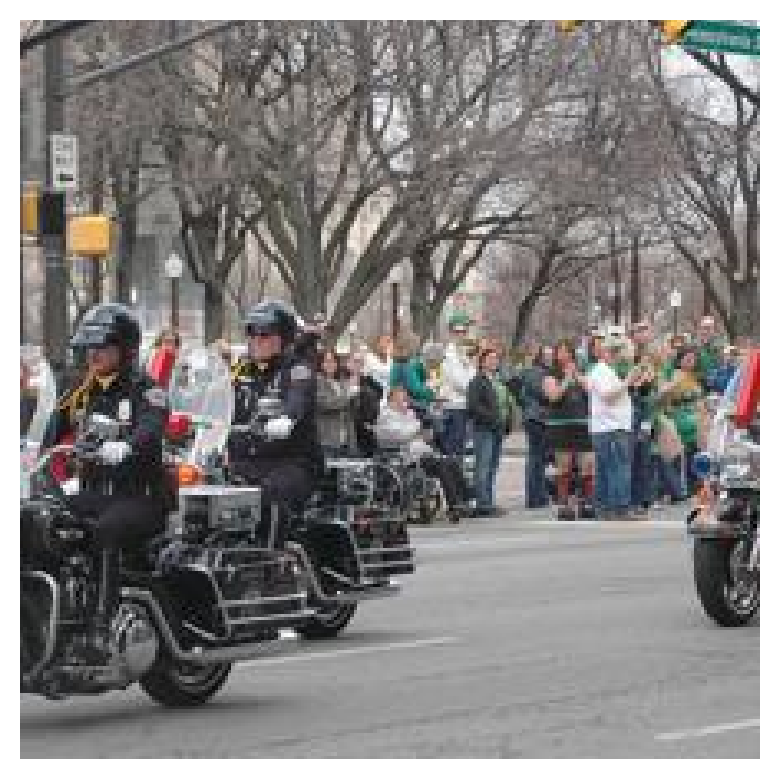

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image


random_index = random.randint(0, train_metadata.shape[0] - 1)

# Get the file name and label values
file_name = train_metadata.loc[random_index, 'file_name']
label_values = train_metadata.loc[random_index]

# Display the file name and label values
print(f"File Name: {file_name}")
print("Label Values:")
print(label_values)

# Load and display the image
image_path = f'carnet_dataset/train/images/{file_name}'  # Adjust the path based on your directory structure
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [18]:
# Split train and validation sets
train_data, val_data = train_test_split(train_metadata, test_size=0.2, random_state=42)



In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom loss function to average MSE of signals and vehicles
def average_mse_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    mse_signal = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))  # MSE for signals
    mse_vehicle = K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))  # MSE for vehicles
    return 0.5 * mse_signal + 0.5 * mse_vehicle

def average_mse_loss_individual(y_true, y_pred):
    mse = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))  # MSE for signals/vehicle
    return mse


# def custom_mse_metric(y_true, y_pred):
#     # Ensure both y_true and y_pred are float32
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
    
#     mse_signal = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))  # MSE for signals
#     mse_vehicle = K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))  # MSE for vehicles
#     return 0.5 * mse_signal + 0.5 * mse_vehicle

# def calculate_ensemble_mse_v1(y_true, y_pred):
#     # Ensure both y_true and y_pred are in float32 format
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     # Calculate MSE for vehicle and signal directly
#     mse_vehicle = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))  # vehicle
#     mse_signal = tf.reduce_mean(tf.square(y_true[:, 1] - y_pred[:, 1]))   # signal

#     # Return average MSE for vehicle and signal
#     return 0.5 * mse_vehicle + 0.5 * mse_signal

In [14]:
# Data generators for training and validation
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['signal', 'vehicle'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)

train_generator_signal = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['signal'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)


train_generator_veh = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['vehicle'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['signal', 'vehicle'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)

val_generator_veh = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['vehicle'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)


val_generator_signal = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='carnet_dataset/train/images',
    x_col='file_name',
    y_col=['signal'],
    target_size=(228, 228),
    batch_size=32,
    class_mode='raw'
)

Found 18582 validated image filenames.
Found 18582 validated image filenames.
Found 18582 validated image filenames.
Found 4646 validated image filenames.
Found 4646 validated image filenames.
Found 4646 validated image filenames.


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, ConvNeXtBase
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras import backend as K  # Use tf.keras.backend instead of keras.backend


# Model creation functions
def create_resnet_model():
    input_layer = Input(shape=(228, 228, 3), name='image_input')
    base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(2, activation='relu')(x) 
    model = Model(inputs=input_layer, outputs=output)
    # for layer in base_model.layers[-3:]:  
    #     layer.trainable = True
    return model

def create_convnext_model():
    input_layer = Input(shape=(228, 228, 3), name='image_input')
    base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='relu')(x)  # Output for vehicle and signal
    model = Model(inputs=input_layer, outputs=output)
    for layer in base_model.layers[-3:]:  
        layer.trainable = True
    return model



# Ensemble prediction function
def ensemble_predict(models, data):
    predictions = [model.predict(data) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Training function
def train_model(model, train_data, validation_data, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=[average_mse_loss]
    )
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
        ]
    )
    return model




In [30]:
# Create and train ResNet model
resnet_model = create_resnet_model()
resnet_model = train_model(resnet_model, train_generator, val_generator, epochs=10)

# Create and train ConvNeXt model
convnext_model = create_convnext_model()
convnext_model = train_model(convnext_model, train_generator,val_generator, epochs=10)

Epoch 1/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 246s 393ms/step - average_mse_loss: 7.8992 - loss: 8.0206 - val_average_mse_loss: 5.0274 - val_loss: 5.1521 - learning_rate: 1.0000e-04
Epoch 2/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 220s 379ms/step - average_mse_loss: 4.8626 - loss: 4.9872 - val_average_mse_loss: 4.4270 - val_loss: 4.5531 - learning_rate: 1.0000e-04
Epoch 3/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 220s 379ms/step - average_mse_loss: 4.2128 - loss: 4.3405 - val_average_mse_loss: 4.2447 - val_loss: 4.3385 - learning_rate: 1.0000e-04
Epoch 4/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 220s 379ms/step - average_mse_loss: 3.9944 - loss: 4.1204 - val_average_mse_loss: 4.0794 - val_loss: 4.2164 - learning_rate: 1.0000e-04
Epoch 5/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 220s 379ms/step - average_mse_loss: 3.8492 - loss: 3.9755 - val_average_mse_loss: 4.0089 - val_loss: 4.1521 - learning_rate: 1.0000e-04
Epoch 6/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 220s 379ms/step - average_mse_loss: 3.7899 - loss: 3.9182 - val_average_mse_loss

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 1: Calculate Validation MSE for Each Model
def calculate_validation_mse(model, val_generator):
    val_preds = []
    val_labels = []
    validation_steps = val_generator.n // val_generator.batch_size

    for i in range(validation_steps):
        batch_data, batch_labels = val_generator[i]
        predictions = model.predict(batch_data)
        val_preds.append(predictions)
        val_labels.append(batch_labels)
    
    # Concatenate predictions and labels for full validation set
    val_preds = np.vstack(val_preds)
    val_labels = np.vstack(val_labels)

    # Calculate MSE for signal and vehicle
    mse_signal = mean_squared_error(val_labels[:, 0], val_preds[:, 0])
    mse_vehicle = mean_squared_error(val_labels[:, 1], val_preds[:, 1])
    avg_mse = 0.5 * (mse_signal + mse_vehicle)
    
    return avg_mse

# Calculate MSE for each model on validation data
val_mse_resnet = calculate_validation_mse(resnet_model, val_generator)
val_mse_convnext = calculate_validation_mse(convnext_model, val_generator)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

In [34]:
print(val_mse_resnet)
print(val_mse_convnext)

total_mse = val_mse_resnet + val_mse_convnext
weight_resnet = 1 - (val_mse_resnet / total_mse)
weight_convnext = 1 - (val_mse_convnext / total_mse)

# Normalize weights to ensure they sum to 1
weights = [weight_resnet, weight_convnext]
weights /= np.sum(weights)

# Step 2: Calculate the weighted MSE
weighted_mse = weight_resnet * val_mse_resnet + weight_convnext * val_mse_convnext

print("Weights for ResNet:", weight_resnet)
print("Weights for ConvNeXt:", weight_convnext)
print("Weighted MSE:", weighted_mse)

3.855003285090265
4.035679819841118
Weights for ResNet: 0.511448725816776
Weights for ConvNeXt: 0.48855127418322397
Weighted MSE: 3.9432730363578035


In [76]:
# Step 3: Make Ensemble Predictions on Test Data
def ensemble_predict(models, data, weights):
    predictions = [model.predict(data) for model in models]
    predictions = np.array(predictions)
    print(weights)
    # Compute weighted average of the predictions
    avg_predictions = np.average(predictions, axis=0, weights=weights)
    return avg_predictions




In [ ]:

ensemble_models = [resnet_model, convnext_model]
ensemble_predictions = ensemble_predict(ensemble_models, val_generator,weights)

In [46]:
# y_true = val_generator.labels  # Assuming labels are available from the generator
# average_mse_loss(y_true, ensemble_predictions)
# print(average_mse_loss)
def ensemble_predict(models, data, weights):
    predictions = [model.predict(data) for model in models]
    predictions = np.array(predictions)
    # Compute weighted average of the predictions
    avg_predictions = np.average(predictions, axis=0, weights=weights)
    return avg_predictions

ensemble_preds = []

validation_steps = val_generator.n // val_generator.batch_size
for i in range(validation_steps):
    batch_data, _ = val_generator[i]
    predictions = ensemble_predict([resnet_model, convnext_model], batch_data, weights)
    ensemble_preds.append(predictions)

# Concatenate all batch predictions
ensemble_preds = np.vstack(ensemble_preds)

# Evaluate the ensemble model
val_labels = []

for i in range(validation_steps):
    _, batch_labels = val_generator[i]
    val_labels.append(batch_labels)

val_labels = np.vstack(val_labels)

# Calculate the ensemble's MSE manually
mse_signal = mean_squared_error(val_labels[:, 0], ensemble_preds[:, 0])
mse_vehicle = mean_squared_error(val_labels[:, 1], ensemble_preds[:, 1])
ensemble_mse = 0.5 * (mse_signal + mse_vehicle)

print(f"Weighted Ensemble MSE: {ensemble_mse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [79]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load score metadata
score_metadata = pd.read_csv('carnet_dataset/score/metadata.csv')

# Define ImageDataGenerator for score data (without augmentation)
score_data_gen = ImageDataGenerator() 

# Create score data generator
score_generator = score_data_gen.flow_from_dataframe(
    dataframe=score_metadata,
    directory='carnet_dataset/score/images',
    x_col='file_name',
    target_size=(228, 228),
    class_mode=None,  # No labels in score data
    shuffle=False
)

Found 5766 validated image filenames.


In [78]:
print(weights)

[0.51144873 0.48855127]


In [86]:



import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load all images from score data
score_data = score_data_gen.flow_from_dataframe(
    dataframe=score_metadata,
    directory='carnet_dataset/score/images',
    x_col='file_name',
    target_size=(228, 228),
    batch_size=score_metadata.shape[0],  # Load all images in one batch
    class_mode=None,
    shuffle=False
)



# Load all data in one go using __getitem__ to get the first (and only) batch
batch_data = score_data[0]

# Make predictions
ensemble_preds = ensemble_predict(
    [resnet_model, convnext_model], 
    batch_data, 
    weights
)

# Create a DataFrame for predictions
score_y_hat = pd.DataFrame(ensemble_preds, columns=['signal', 'vehicle'])





Found 5766 validated image filenames.
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 319ms/step


# Saving the model and predictions

In [87]:
# Assert checks for the final predictions
assert type(score_y_hat) == pd.DataFrame
assert score_y_hat.shape == (score_metadata.shape[0], 2)
assert (score_y_hat.columns == ['signal', 'vehicle']).all()

# Save the predictions as a parquet file
import os 
model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [89]:

score_y_hat

,signal,vehicle
0,0.123893,6.431757
1,0.000000,4.603394
2,0.358292,1.173383
3,0.403487,3.591282
4,0.000000,4.238861
...,...,...
5761,0.000000,3.198235
5762,0.000000,4.816568
5763,0.201459,3.178390
5764,0.000000,1.852883


In [91]:
import os 
model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Save each model's definition (JSON) and weights (H5)
for model, name in zip(
    [resnet_model, convnext_model],  # List of individual models
    ['resnet_model', 'convnext_model']  # Corresponding names
):
    # Save model architecture
    model_json = model.to_json()
    with open(f'{model_dir}/{name}_model.json', 'w') as json_file:
        json_file.write(model_json)
    
    # Save model weights with the required .weights.h5 extension
    model.save_weights(f'{model_dir}/{name}_weights.weights.h5')


In [27]:
# Next, save each model's defition (JSON file) and parameters (H5 file).

In [28]:
# You now have the following files to be submit:
# 1. This notebook and any other Python code you used to train the final model.
# 2. definitions of all trained models
# 3. parameters of all trained models
# 4. score_y_hat.parquet - the model's output on the score segment